In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r"H:\Nasa Space Apps 2025\data\cleaned_data.csv")
df.head()

,kepid,kepoi_name,koi_disposition,koi_score,koi_period,koi_duration,koi_depth,koi_time0bk,koi_prad,koi_ror,...,koi_period_err1,koi_period_err2,koi_duration_err1,koi_duration_err2,koi_depth_err1,koi_depth_err2,koi_prad_err1,koi_prad_err2,koi_steff_err1,koi_steff_err2
0,10797460,K00752.01,CONFIRMED,1.000,9.488036,2.95750,615.8,170.538750,2.26,0.022344,...,2.775000e-05,-2.775000e-05,0.08190,-0.08190,19.5,-19.5,0.26,-0.15,81.0,-81.0
1,10797460,K00752.02,CONFIRMED,0.969,54.418383,4.50700,874.8,162.513840,2.83,0.027954,...,2.479000e-04,-2.479000e-04,0.11600,-0.11600,35.5,-35.5,0.32,-0.19,81.0,-81.0
2,10811496,K00753.01,CANDIDATE,0.000,19.899140,1.78220,10829.0,175.850252,14.60,0.154046,...,1.494000e-05,-1.494000e-05,0.03410,-0.03410,171.0,-171.0,3.92,-1.31,158.0,-176.0
3,10848459,K00754.01,FALSE POSITIVE,0.000,1.736952,2.40641,8079.2,170.307565,33.46,0.387394,...,2.630000e-07,-2.630000e-07,0.00537,-0.00537,12.8,-12.8,8.50,-2.83,157.0,-174.0
4,10854555,K00755.01,CONFIRMED,1.000,2.525592,1.65450,603.3,171.595550,2.75,0.024064,...,3.761000e-06,-3.761000e-06,0.04200,-0.04200,16.9,-16.9,0.88,-0.35,169.0,-211.0


In [3]:
# Keep all three classes - don't merge FALSE POSITIVE
# df['koi_disposition'] = df['koi_disposition'].replace('FALSE POSITIVE', 'CANDIDATE')
df['koi_disposition'].value_counts()

koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64

In [4]:
df = df.drop(columns=['kepoi_name','kepid'])
df.head()

,koi_disposition,koi_score,koi_period,koi_duration,koi_depth,koi_time0bk,koi_prad,koi_ror,koi_dor,koi_impact,...,koi_period_err1,koi_period_err2,koi_duration_err1,koi_duration_err2,koi_depth_err1,koi_depth_err2,koi_prad_err1,koi_prad_err2,koi_steff_err1,koi_steff_err2
0,CONFIRMED,1.000,9.488036,2.95750,615.8,170.538750,2.26,0.022344,24.810,0.146,...,2.775000e-05,-2.775000e-05,0.08190,-0.08190,19.5,-19.5,0.26,-0.15,81.0,-81.0
1,CONFIRMED,0.969,54.418383,4.50700,874.8,162.513840,2.83,0.027954,77.900,0.586,...,2.479000e-04,-2.479000e-04,0.11600,-0.11600,35.5,-35.5,0.32,-0.19,81.0,-81.0
2,CANDIDATE,0.000,19.899140,1.78220,10829.0,175.850252,14.60,0.154046,53.500,0.969,...,1.494000e-05,-1.494000e-05,0.03410,-0.03410,171.0,-171.0,3.92,-1.31,158.0,-176.0
3,FALSE POSITIVE,0.000,1.736952,2.40641,8079.2,170.307565,33.46,0.387394,3.278,1.276,...,2.630000e-07,-2.630000e-07,0.00537,-0.00537,12.8,-12.8,8.50,-2.83,157.0,-174.0
4,CONFIRMED,1.000,2.525592,1.65450,603.3,171.595550,2.75,0.024064,8.750,0.701,...,3.761000e-06,-3.761000e-06,0.04200,-0.04200,16.9,-16.9,0.88,-0.35,169.0,-211.0


In [5]:
df.columns

Index(['koi_disposition', 'koi_score', 'koi_period', 'koi_duration',
       'koi_depth', 'koi_time0bk', 'koi_prad', 'koi_ror', 'koi_dor',
       'koi_impact', 'koi_incl', 'koi_srad', 'koi_smass', 'koi_steff',
       'koi_slogg', 'koi_smet', 'koi_kepmag', 'koi_fpflag_nt', 'koi_fpflag_ss',
       'koi_fpflag_co', 'koi_fpflag_ec', 'koi_vet_stat', 'koi_vet_date',
       'koi_disp_prov', 'koi_period_err1', 'koi_period_err2',
       'koi_duration_err1', 'koi_duration_err2', 'koi_depth_err1',
       'koi_depth_err2', 'koi_prad_err1', 'koi_prad_err2', 'koi_steff_err1',
       'koi_steff_err2'],
      dtype='object')

In [6]:
X = df.drop(columns=['koi_disposition', 'koi_vet_stat', 'koi_vet_date', 'koi_disp_prov'])
y = df['koi_disposition']

print("Original class distribution:")
print(y.value_counts())
print(f"Total samples: {len(y)}")

Original class distribution:
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64
Total samples: 9564


In [7]:
df_combined = pd.concat([X, y], axis=1)

df_candidate = df_combined[df_combined.koi_disposition == 'CANDIDATE']
df_confirmed = df_combined[df_combined.koi_disposition == 'CONFIRMED']
df_false_positive = df_combined[df_combined.koi_disposition == 'FALSE POSITIVE']

min_samples = min(len(df_candidate), len(df_confirmed), len(df_false_positive))

print(f"Original class sizes:")
print(f"CANDIDATE: {len(df_candidate)}")
print(f"CONFIRMED: {len(df_confirmed)}")
print(f"FALSE POSITIVE: {len(df_false_positive)}")
print(f"\nDownsampling all classes to: {min_samples}")

df_candidate_downsampled = resample(df_candidate, 
                                    replace=False,
                                    n_samples=min_samples,
                                    random_state=42)

df_confirmed_downsampled = resample(df_confirmed, 
                                    replace=False,
                                    n_samples=min_samples,
                                    random_state=42)

df_false_positive_downsampled = resample(df_false_positive, 
                                         replace=False,
                                         n_samples=min_samples,
                                         random_state=42)

df_balanced = pd.concat([df_candidate_downsampled, 
                        df_confirmed_downsampled, 
                        df_false_positive_downsampled])

print(f"\nBalanced class distribution:")
print(df_balanced['koi_disposition'].value_counts())

Original class sizes:
CANDIDATE: 1979
CONFIRMED: 2746
FALSE POSITIVE: 4839

Downsampling all classes to: 1979

Balanced class distribution:
koi_disposition
CANDIDATE         1979
CONFIRMED         1979
FALSE POSITIVE    1979
Name: count, dtype: int64


In [8]:
X_balanced = df_balanced.drop(columns=['koi_disposition'])
y_balanced = df_balanced['koi_disposition']

print(f"Features (X): {X_balanced.shape}")
print(f"Target (y): {y_balanced.shape}")
print(f"\nClasses:")
print(y_balanced.value_counts())

Features (X): (5937, 30)
Target (y): (5937,)

Classes:
koi_disposition
CANDIDATE         1979
CONFIRMED         1979
FALSE POSITIVE    1979
Name: count, dtype: int64


In [9]:
y_balanced[:5]

4247    CANDIDATE
1196    CANDIDATE
6428    CANDIDATE
8240    CANDIDATE
7485    CANDIDATE
Name: koi_disposition, dtype: object

In [10]:
label_encoder = LabelEncoder()
y_balanced_encoded = label_encoder.fit_transform(y_balanced)

print(f"\nOriginal y_balanced: {y_balanced[:10].values}")
print(f"Encoded y_balance: {y_balanced_encoded[:10]}")


Original y_balanced: ['CANDIDATE' 'CANDIDATE' 'CANDIDATE' 'CANDIDATE' 'CANDIDATE' 'CANDIDATE'
 'CANDIDATE' 'CANDIDATE' 'CANDIDATE' 'CANDIDATE']
Encoded y_balance: [0 0 0 0 0 0 0 0 0 0]


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced_encoded, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4749, 30), (1188, 30), (4749,), (1188,))

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train[:5]

array([[-0.97052229, -0.04929159, -0.6225659 , -0.26653742, -0.53905368,
        -0.03760452, -0.07859937, -0.074544  , -0.16655624,  0.22149332,
        -0.11780077, -0.03754722,  0.2230888 ,  0.52512161,  0.08151536,
         0.72880479, -0.34380384,  2.3406952 , -0.38136779, -0.28032621,
        -0.27625364,  0.27624187,  0.03993418, -0.03993451, -0.09695698,
         0.09692897, -0.04337086,  0.03299279, -0.03202869, -0.25458724],
       [-1.00206385,  0.23892281,  0.29203587, -0.2647369 ,  3.48067057,
        -0.03689007, -0.0766976 ,  0.39389349, -0.08241234,  0.44002989,
        -0.01378773,  0.31697198,  1.00421577, -0.47169851, -0.58554981,
        -1.9869198 ,  2.90863531, -0.4272235 , -0.38136779, -0.28032621,
         1.46636872, -1.4663803 ,  0.45000619, -0.45000651, -0.07876889,
         0.07874084, -0.04079882,  0.03219585,  0.15939907, -0.49154766],
       [-0.95009971,  0.15976587,  1.94160158, -0.24587546,  0.22064433,
        -0.03661889, -0.06979828,  0.08818229, -0

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [14]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train_tensor = torch.tensor(y_train, dtype=torch.int64).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64).to(device)

In [15]:
X_train_tensor[:5], y_train_tensor[:5]

(tensor([[-0.9705, -0.0493, -0.6226, -0.2665, -0.5391, -0.0376, -0.0786, -0.0745,
          -0.1666,  0.2215, -0.1178, -0.0375,  0.2231,  0.5251,  0.0815,  0.7288,
          -0.3438,  2.3407, -0.3814, -0.2803, -0.2763,  0.2762,  0.0399, -0.0399,
          -0.0970,  0.0969, -0.0434,  0.0330, -0.0320, -0.2546],
         [-1.0021,  0.2389,  0.2920, -0.2647,  3.4807, -0.0369, -0.0767,  0.3939,
          -0.0824,  0.4400, -0.0138,  0.3170,  1.0042, -0.4717, -0.5855, -1.9869,
           2.9086, -0.4272, -0.3814, -0.2803,  1.4664, -1.4664,  0.4500, -0.4500,
          -0.0788,  0.0787, -0.0408,  0.0322,  0.1594, -0.4915],
         [-0.9501,  0.1598,  1.9416, -0.2459,  0.2206, -0.0366, -0.0698,  0.0882,
          -0.1827,  0.4400, -0.1571, -0.8946, -1.4102,  0.7873,  0.2298,  1.2067,
          -0.3438, -0.4272, -0.3814, -0.2803,  3.0970, -3.0970,  1.6384, -1.6384,
           0.1053, -0.1054, -0.0431,  0.0328,  0.0956,  0.3169],
         [ 0.6882, -0.0285, -0.4323, -0.2561, -0.3638, -0.0310, -0.

In [16]:
class Classifier(nn.Module):
  def __init__(self, input_size, num_classes):
    super(Classifier, self).__init__()
    self.layer_1 = nn.Linear(input_size, 256)
    self.bn1 = nn.BatchNorm1d(256)
    self.dropout1 = nn.Dropout(0.3)
    
    self.layer_2 = nn.Linear(256, 128)
    self.bn2 = nn.BatchNorm1d(128)
    self.dropout2 = nn.Dropout(0.3)
    
    self.layer_3 = nn.Linear(128, 64)
    self.bn3 = nn.BatchNorm1d(64)
    self.dropout3 = nn.Dropout(0.2)
    
    self.layer_4 = nn.Linear(64, num_classes)
    
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.layer_1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.dropout1(x)
    
    x = self.layer_2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.dropout2(x)
    
    x = self.layer_3(x)
    x = self.bn3(x)
    x = self.relu(x)
    x = self.dropout3(x)
    
    x = self.layer_4(x)
    return x

In [17]:
input_size = X_train.shape[1]
num_classes = 3

model = Classifier(input_size, num_classes).to(device)

In [18]:
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

c:\Users\CRIZMA\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [19]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [20]:
num_epochs = 500
best_loss = float('inf')
patience = 50
patience_counter = 0

train_losses = []
train_accs = []

for epoch in range(num_epochs):
  model.train()

  # forward
  outputs = model(X_train_tensor)
  loss = criterion(outputs, y_train_tensor)

  _, predicted = torch.max(outputs, 1)
  acc = accuracy_score(y_train_tensor.cpu().numpy(), predicted.cpu().numpy())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  scheduler.step(loss)
  
  train_losses.append(loss.item())
  train_accs.append(acc)
  
  if loss.item() < best_loss:
    best_loss = loss.item()
    patience_counter = 0
    torch.save(model.state_dict(), 'best_model.pth')
  else:
    patience_counter += 1
  
  if epoch % 25 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}] \t Loss: {loss.item():.4f} | Accuracy: {acc:.4f} | LR: {optimizer.param_groups[0]["lr"]:.6f}')
  
  if patience_counter >= patience:
    print(f'\nEarly stopping at epoch {epoch+1}')
    break

model.load_state_dict(torch.load('best_model.pth'))
print(f'\nBest training loss: {best_loss:.4f}')

Epoch [1/500] 	 Loss: 1.1639 | Accuracy: 0.3171 | LR: 0.001000
Epoch [26/500] 	 Loss: 0.4139 | Accuracy: 0.8503 | LR: 0.001000
Epoch [51/500] 	 Loss: 0.3295 | Accuracy: 0.8716 | LR: 0.001000
Epoch [76/500] 	 Loss: 0.2945 | Accuracy: 0.8882 | LR: 0.001000
Epoch [101/500] 	 Loss: 0.2736 | Accuracy: 0.8916 | LR: 0.001000
Epoch [126/500] 	 Loss: 0.2650 | Accuracy: 0.8928 | LR: 0.001000
Epoch [151/500] 	 Loss: 0.2611 | Accuracy: 0.8958 | LR: 0.000500
Epoch [176/500] 	 Loss: 0.2545 | Accuracy: 0.8966 | LR: 0.000500
Epoch [201/500] 	 Loss: 0.2418 | Accuracy: 0.9057 | LR: 0.000500
Epoch [226/500] 	 Loss: 0.2412 | Accuracy: 0.9019 | LR: 0.000250
Epoch [251/500] 	 Loss: 0.2407 | Accuracy: 0.9046 | LR: 0.000125
Epoch [276/500] 	 Loss: 0.2396 | Accuracy: 0.9067 | LR: 0.000031
Epoch [301/500] 	 Loss: 0.2363 | Accuracy: 0.9046 | LR: 0.000008
Epoch [326/500] 	 Loss: 0.2391 | Accuracy: 0.9052 | LR: 0.000002
Epoch [351/500] 	 Loss: 0.2354 | Accuracy: 0.9044 | LR: 0.000000

Early stopping at epoch 372



C:\Users\CRIZMA\AppData\Local\Temp\ipykernel_30712\3195724986.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


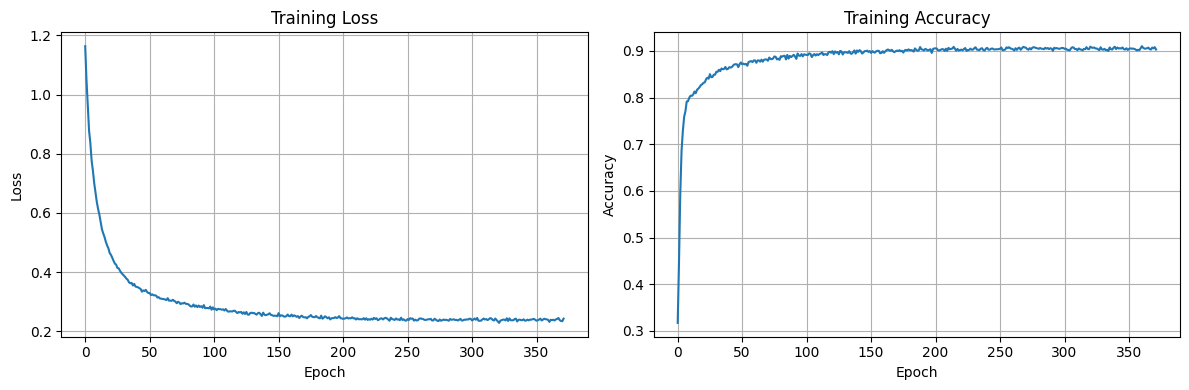

In [21]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
model.eval()
with torch.no_grad():
  outputs = model(X_test_tensor)
  _, predicted = torch.max(outputs, 1)
  acc = accuracy_score(y_test_tensor.cpu().numpy(), predicted.cpu().numpy())

  predicted_tensor = predicted.clone().detach()  
  loss = criterion(outputs, y_test_tensor)
  
print(f'Test Loss: {loss.item():.4f} | Accuracy: {acc:.4f}')

Test Loss: 0.2633 | Accuracy: 0.8990


Classification Report:
                precision    recall  f1-score   support

     CANDIDATE       0.87      0.85      0.86       415
     CONFIRMED       0.84      0.88      0.86       376
FALSE POSITIVE       0.99      0.97      0.98       397

      accuracy                           0.90      1188
     macro avg       0.90      0.90      0.90      1188
  weighted avg       0.90      0.90      0.90      1188


Confusion Matrix:


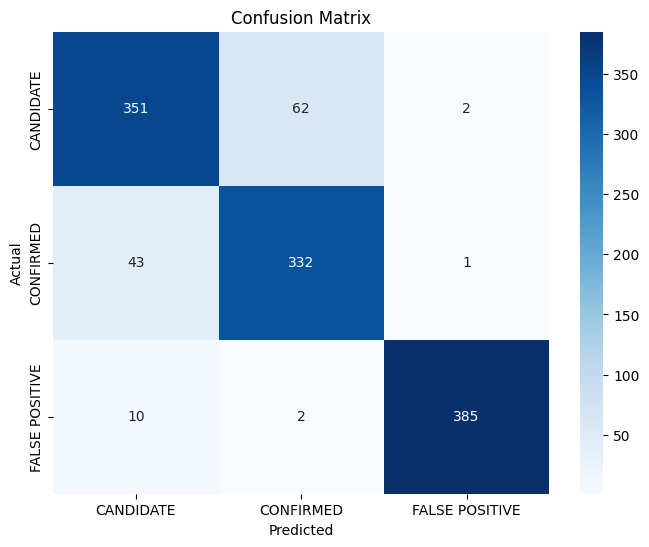

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model.eval()
with torch.no_grad():
  outputs = model(X_test_tensor)
  _, predicted = torch.max(outputs, 1)
  
y_test_pred = predicted.cpu().numpy()
y_test_actual = y_test_tensor.cpu().numpy()

print("Classification Report:")
print(classification_report(y_test_actual, y_test_pred, 
                          target_names=label_encoder.classes_))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_actual, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

---

In [24]:
import pickle
import joblib

torch.save(model.state_dict(), 'exoplanet_classifier_model.pth')

joblib.dump(scaler, 'exoplanet_scaler.pkl')

joblib.dump(label_encoder, 'exoplanet_label_encoder.pkl')

model_info = {
    'input_size': input_size,
    'num_classes': num_classes,
    'feature_names': list(X_balanced.columns),
    'label_mapping': dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
}

with open('model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print(f"\nModel info: {model_info}")


Model info: {'input_size': 30, 'num_classes': 3, 'feature_names': ['koi_score', 'koi_period', 'koi_duration', 'koi_depth', 'koi_time0bk', 'koi_prad', 'koi_ror', 'koi_dor', 'koi_impact', 'koi_incl', 'koi_srad', 'koi_smass', 'koi_steff', 'koi_slogg', 'koi_smet', 'koi_kepmag', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period_err1', 'koi_period_err2', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad_err1', 'koi_prad_err2', 'koi_steff_err1', 'koi_steff_err2'], 'label_mapping': {'CANDIDATE': 0, 'CONFIRMED': 1, 'FALSE POSITIVE': 2}}


In [25]:
def load_and_predict(features):
    import torch
    import torch.nn as nn
    import joblib
    import pickle
    import numpy as np
    
    scaler = joblib.load('exoplanet_scaler.pkl')
    label_encoder = joblib.load('exoplanet_label_encoder.pkl')
    
    with open('model_info.pkl', 'rb') as f:
        model_info = pickle.load(f)
    
    class Classifier(nn.Module):
        def __init__(self, input_size, num_classes):
            super(Classifier, self).__init__()
            self.layer_1 = nn.Linear(input_size, 256)
            self.bn1 = nn.BatchNorm1d(256)
            self.dropout1 = nn.Dropout(0.3)
            
            self.layer_2 = nn.Linear(256, 128)
            self.bn2 = nn.BatchNorm1d(128)
            self.dropout2 = nn.Dropout(0.3)
            
            self.layer_3 = nn.Linear(128, 64)
            self.bn3 = nn.BatchNorm1d(64)
            self.dropout3 = nn.Dropout(0.2)
            
            self.layer_4 = nn.Linear(64, num_classes)
            
            self.relu = nn.ReLU()

        def forward(self, x):
            x = self.layer_1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.dropout1(x)
            
            x = self.layer_2(x)
            x = self.bn2(x)
            x = self.relu(x)
            x = self.dropout2(x)
            
            x = self.layer_3(x)
            x = self.bn3(x)
            x = self.relu(x)
            x = self.dropout3(x)
            
            x = self.layer_4(x)
            return x
    
    model = Classifier(model_info['input_size'], model_info['num_classes'])
    model.load_state_dict(torch.load('exoplanet_classifier_model.pth', weights_only=False))
    model.eval()
    
    features = np.array(features).reshape(1, -1)
    features_scaled = scaler.transform(features)
    
    features_tensor = torch.tensor(features_scaled, dtype=torch.float32)
    
    with torch.no_grad():
        outputs = model(features_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    prediction = predicted.item()
    confidence = probabilities[0][prediction].item()
    label = label_encoder.inverse_transform([prediction])[0]
    
    return prediction, confidence, label

In [26]:
test_sample = X_test[0]
test_sample_original = scaler.inverse_transform(test_sample.reshape(1, -1))[0]  # original

print(f"Original features (first 5): {test_sample_original[:5]}")
print(f"Expected label: {label_encoder.inverse_transform([y_test[0]])[0]}")

prediction, confidence, predicted_label = load_and_predict(test_sample_original)

print(f"Prediction: {prediction}")
print(f"Confidence: {confidence:.4f}")
print(f"Label: {predicted_label}")
print(f"Correct: {predicted_label == label_encoder.inverse_transform([y_test[0]])[0]}")

Original features (first 5): [  0.998        3.76562031   1.288      232.6        131.75562   ]
Expected label: CANDIDATE
Prediction: 0
Confidence: 0.7267
Label: CANDIDATE
Correct: True


C:\Users\CRIZMA\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
